# DTSA 5511 Final Project
## Pneumonia detection via X-ray image

Using a dataset from kaggle, my goal is to build a model that can classify an image as either "normal" or "pneumonia" (meaning the subject of the image has pneumonia.) I will achieve this using a convolutional neural network. I used a guide from the Keras documentation to build the first model, then created a model with a different architecture to compare the results.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from glob import glob

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, BatchNormalization, Activation, AveragePooling2D
import numpy as np
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from tensorflow import data as tf_data

import cv2
import random

from PIL import Image
from dask import bag
from dask.diagnostics import ProgressBar

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


## The Data

The dataset consists of 2 directories, Train and Test. Each of which contain 2 subfolders 'NORMAL' and 'PNEUMONIA'. Each of those subfolders contains images of x-rays. The images in the "NORMAL" folder are x-rays of subjects who do not have pneumonia, while the images in the "Pneumonia" folders are of subject who do have it.

The dataset can be downloaded from: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
train_dir = "/kaggle/input/labeled-chest-xray-images/chest_xray/train"
test_dir = "/kaggle/input/labeled-chest-xray-images/chest_xray/test"

train_pos = "/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA"
train_neg = "/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL"

test_pos = "/kaggle/input/labeled-chest-xray-images/chest_xray/test/PNEUMONIA"
test_neg = "/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL"

df_test1 = pd.DataFrame({'filename': glob(os.path.join(test_pos, '*.jpeg'))})
df_test1['id'] = df_test1.filename.map(lambda x:x.split('/')[7])
df_test1['label'] = '1'
print('test pneumonia: ', len(df_test1))

df_test2 = pd.DataFrame({'filename': glob(os.path.join(test_neg, '*.jpeg'))})
df_test2['id'] = df_test2.filename.map(lambda x:x.split('/')[7])
df_test2['label'] = '0'
print('test normal: ', len(df_test2))

df_train1 = pd.DataFrame({'filename': glob(os.path.join(train_pos, '*.jpeg'))})
df_train1['id'] = df_train1.filename.map(lambda x:x.split('/')[7])
df_train1['label'] = '1'
print('train pneumonia: ', len(df_train1))

df_train2 = pd.DataFrame({'filename': glob(os.path.join(train_neg, '*.jpeg'))})
df_train2['id'] = df_train2.filename.map(lambda x:x.split('/')[7])
df_train2['label'] = '0'
print('train normal: ', len(df_train2))

df_test = pd.concat([df_test1, df_test2], axis=0, ignore_index=True)

df_train = pd.concat([df_train1, df_train2], axis=0,ignore_index=True)




test pneumonia:  390
test normal:  234
train pneumonia:  3883
train normal:  1349


In [3]:
path_norm = '/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/'
path_pneu = '/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/'

pneumonia = os.listdir("/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA")
normal = os.listdir("/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL")



### Exploratory Data Analysis

Below I have completed the EDA for this project. I looked at how many of the images in the dataset are labeled 'normal' vs. how many are labeled 'pneumonia', I looked at sample images from each group, and I plotted the size of the all of the images in the training dataset.


In [4]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/input/labeled-chest-xray-images/chest_xray/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Using 1046 files for validation.


In [5]:
df_train.describe()

,filename,id,label
count,5232,5232,5232
unique,5232,5232,2
top,/kaggle/input/labeled-chest-xray-images/chest_...,NORMAL-1456124-0001.jpeg,1
freq,1,1,3883


In [6]:
df_test.describe()

,filename,id,label
count,624,624,624
unique,624,624,2
top,/kaggle/input/labeled-chest-xray-images/chest_...,NORMAL-7738170-0001.jpeg,1
freq,1,1,390


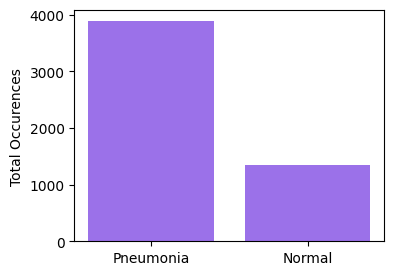

['Pneumonia', 'Normal'] [3883, 1349]


In [7]:
neg = (df_train['label'] == '0').sum()

pos = (df_train['label'] == '1').sum()

x = ["Pneumonia", "Normal"]
y = [pos, neg]

print()

fig = plt.figure(figsize=(4,3))

plt.bar(x,y, color='#9b71e9')
plt.ylabel("Total Occurences")
plt.show()

print(x,y)

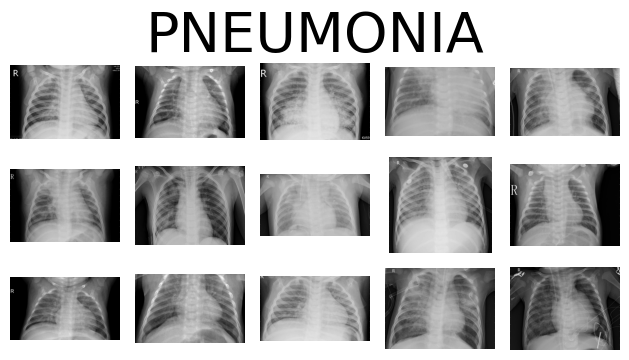

In [8]:
for i in range(15):
    plt.subplot(4,5, i+1)
    img = plt.imread(os.path.join(path_pneu, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    if i == 2:
        plt.title("PNEUMONIA", fontsize=40)
plt.tight_layout()

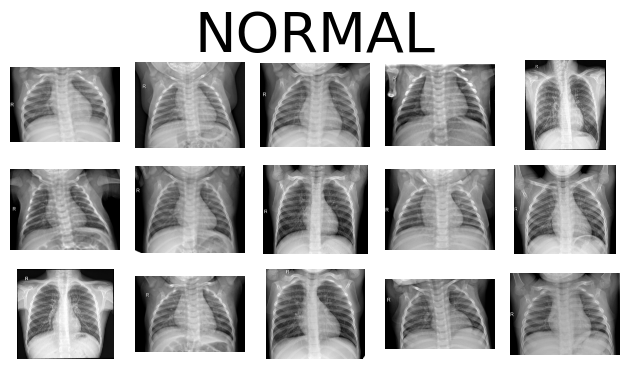

In [9]:
for i in range(15):
    plt.subplot(4,5, i+1)
    img = plt.imread(os.path.join(path_norm, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    if i == 2:
        plt.title("NORMAL", fontsize=40)
plt.tight_layout()

In [10]:
def get_dims(file):
    img = Image.open(file)
    w = img.width 
    h = img.height
    return h,w

In [11]:
filelist = df_train['filename'].to_list()

dim_list = []

for file in filelist:
    dim_list.append(get_dims(file))

<class 'numpy.int64'>


Text(0.5, 1.0, 'Image Sizes in Pixels')

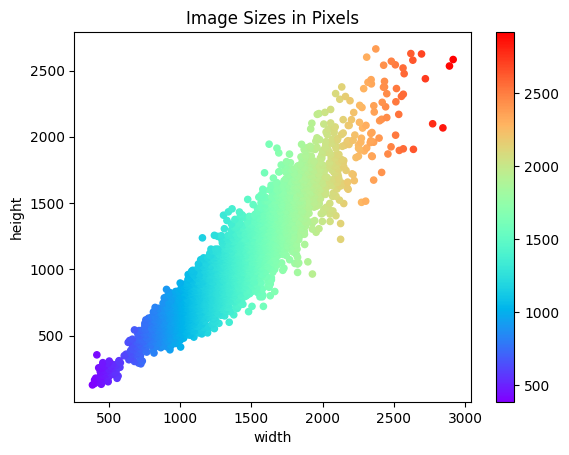

In [12]:
dims_df = pd.DataFrame(dim_list, columns=['height', 'width'])
sizes = dims_df.groupby(['height','width']).size().reset_index().rename(columns={0:'count'})

sizes.plot.scatter(x='width', y='height', c=sizes['width'],
            cmap='rainbow')

print(type(sizes['width'][1]))

plt.title('Image Sizes in Pixels')

In [13]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

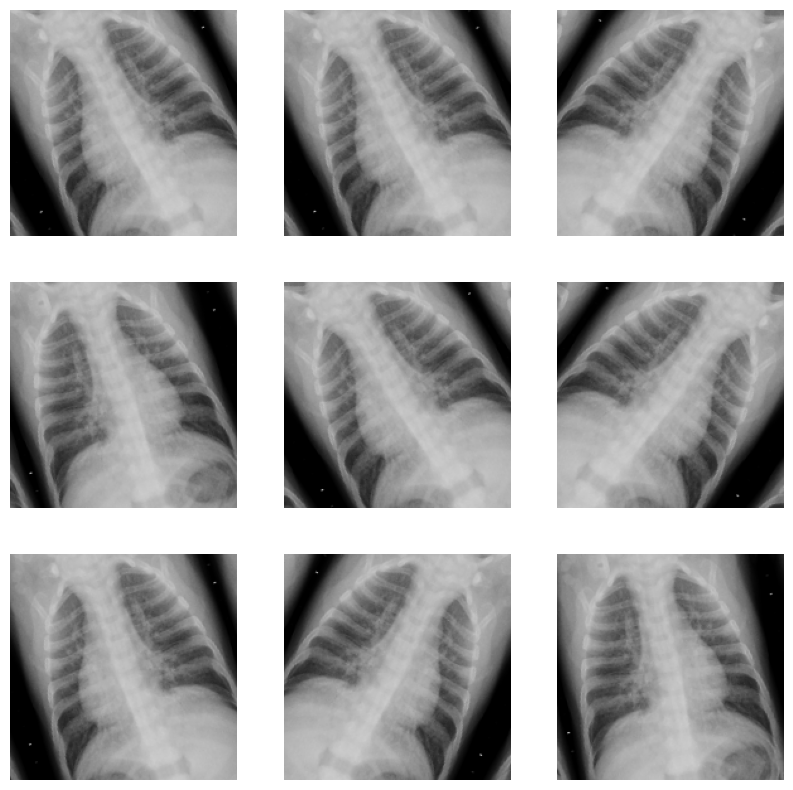

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## The model

In [15]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

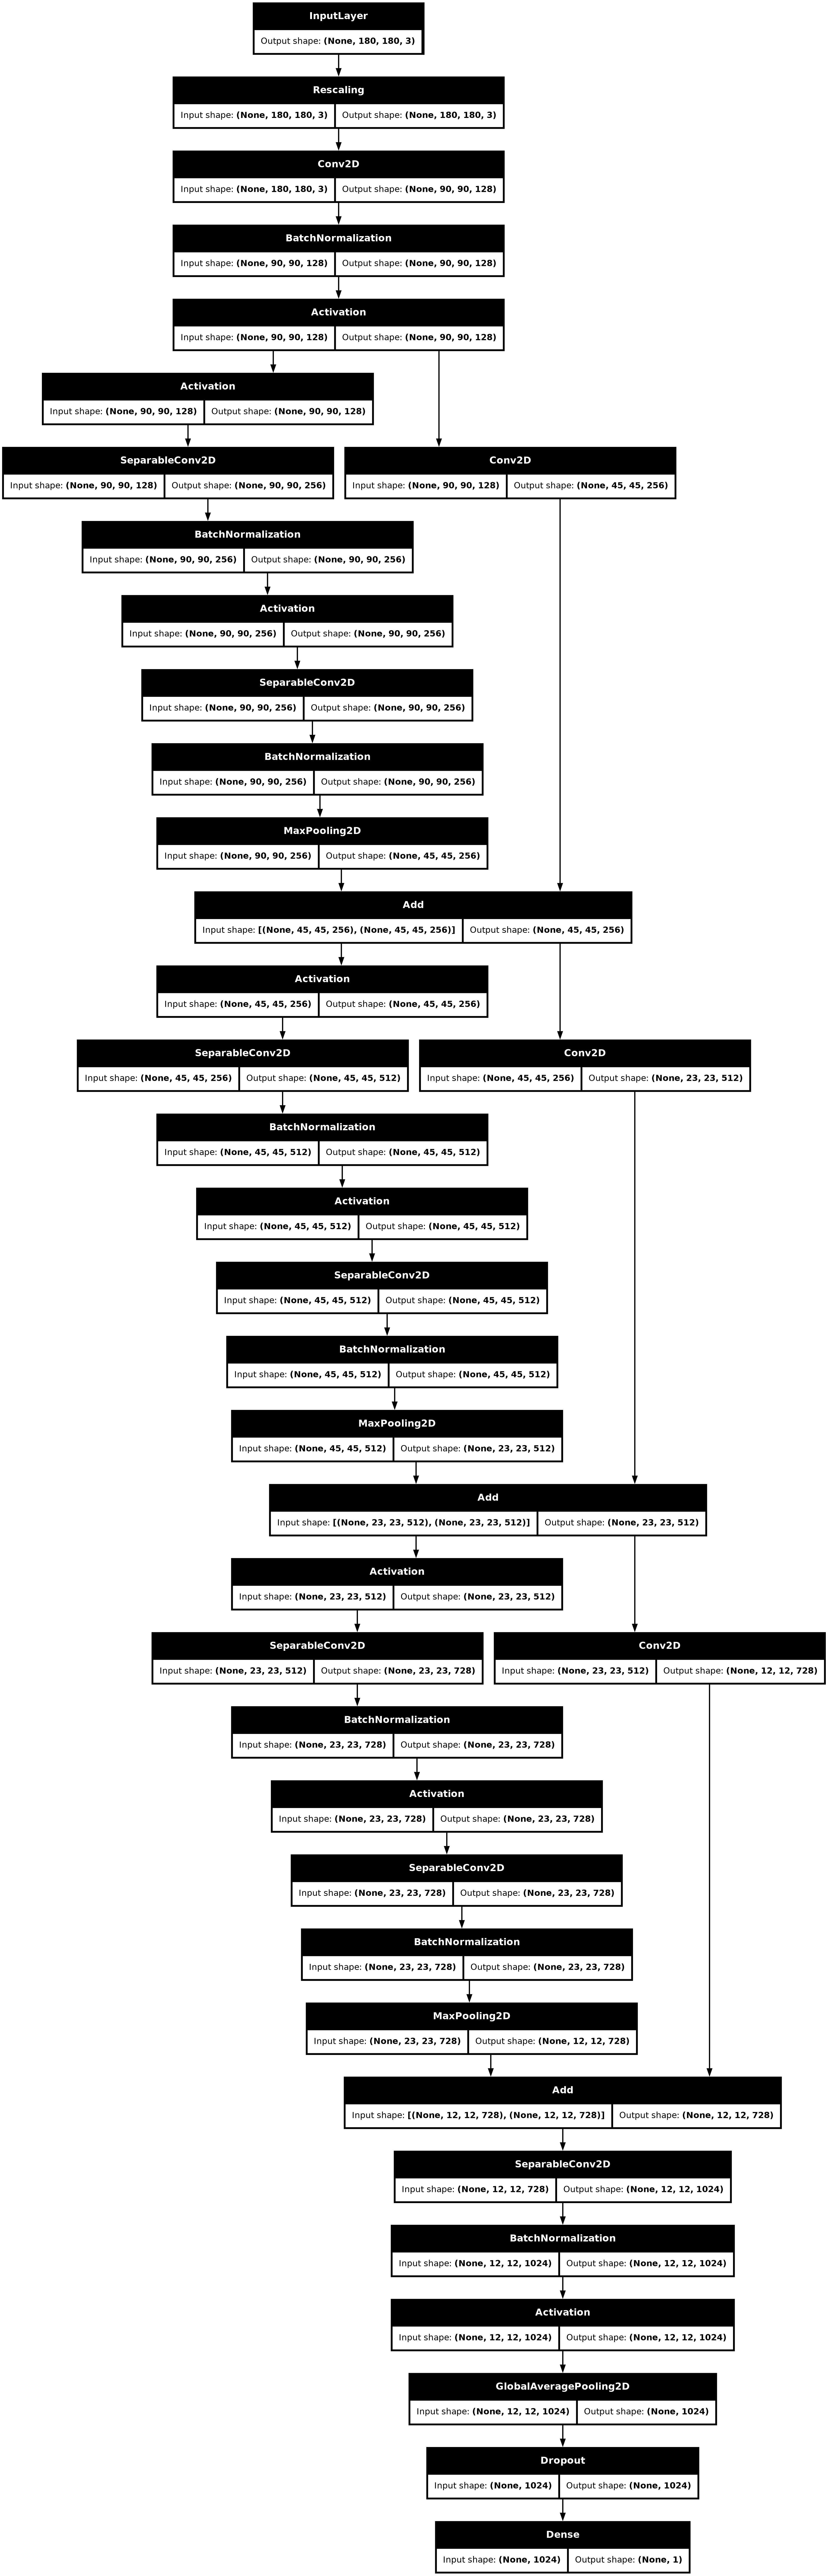

In [16]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [17]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model_hist = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


I0000 00:00:1733796235.805351     968 service.cc:145] XLA service 0x5b069429b7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733796235.805448     968 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-10 02:04:12.354016: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,256,45,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,512,23,23]{3,2,1,0}, f32[512,256,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-10 02:04:12.506993: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.153098972s
Trying algorithm eng0{} for conv

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - acc: 0.7795 - loss: 0.3551

2024-12-10 02:05:33.806353: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[90,728,23,23]{3,2,1,0}, f32[90,728,23,23]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-10 02:05:33.834701: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.028551333s
Trying algorithm eng0{} for conv (f32[728,728,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[90,728,23,23]{3,2,1,0}, f32[90,728,23,23]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv

33/33 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - acc: 0.7850 - loss: 0.3495 - val_acc: 0.2572 - val_loss: 0.6236
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 770ms/step - acc: 0.9395 - loss: 0.1490 - val_acc: 0.7428 - val_loss: 0.5752
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 769ms/step - acc: 0.9534 - loss: 0.1354 - val_acc: 0.7428 - val_loss: 0.5792
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 765ms/step - acc: 0.9526 - loss: 0.1170 - val_acc: 0.7428 - val_loss: 0.6404
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 770ms/step - acc: 0.9562 - loss: 0.1113 - val_acc: 0.7428 - val_loss: 0.7686
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 745ms/step - acc: 0.9676 - loss: 0.0942 - val_acc: 0.7428 - val_loss: 0.9619
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 755ms/step - acc: 0.9609 - loss: 0.0974 - val_acc: 0.7428 - val_loss: 1.1999
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 756ms/step - acc: 0.9662 - loss: 0.0882 - val_acc: 0.7428 - val_loss: 1.5112
Epoch 9/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 767ms/step - acc: 0

## The new model



In [18]:
#batch_size = 256
learning_rate = 0.0001

In [19]:
target_size = (224, 224)

basic_img_gen = ImageDataGenerator(rescale=1./255)
train_gen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, vertical_flip=True, rotation_range=30, fill_mode='nearest')
train_set = train_gen.flow_from_directory(train_dir, 
                                          class_mode = "binary", 
                                          batch_size = batch_size, 
                                          target_size = target_size)
validation_set = basic_img_gen.flow_from_directory(train_dir, 
                                                   class_mode = "binary", 
                                                   batch_size = batch_size, 
                                                   target_size = target_size)

Found 5232 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [20]:
opt = Adam(learning_rate=learning_rate)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


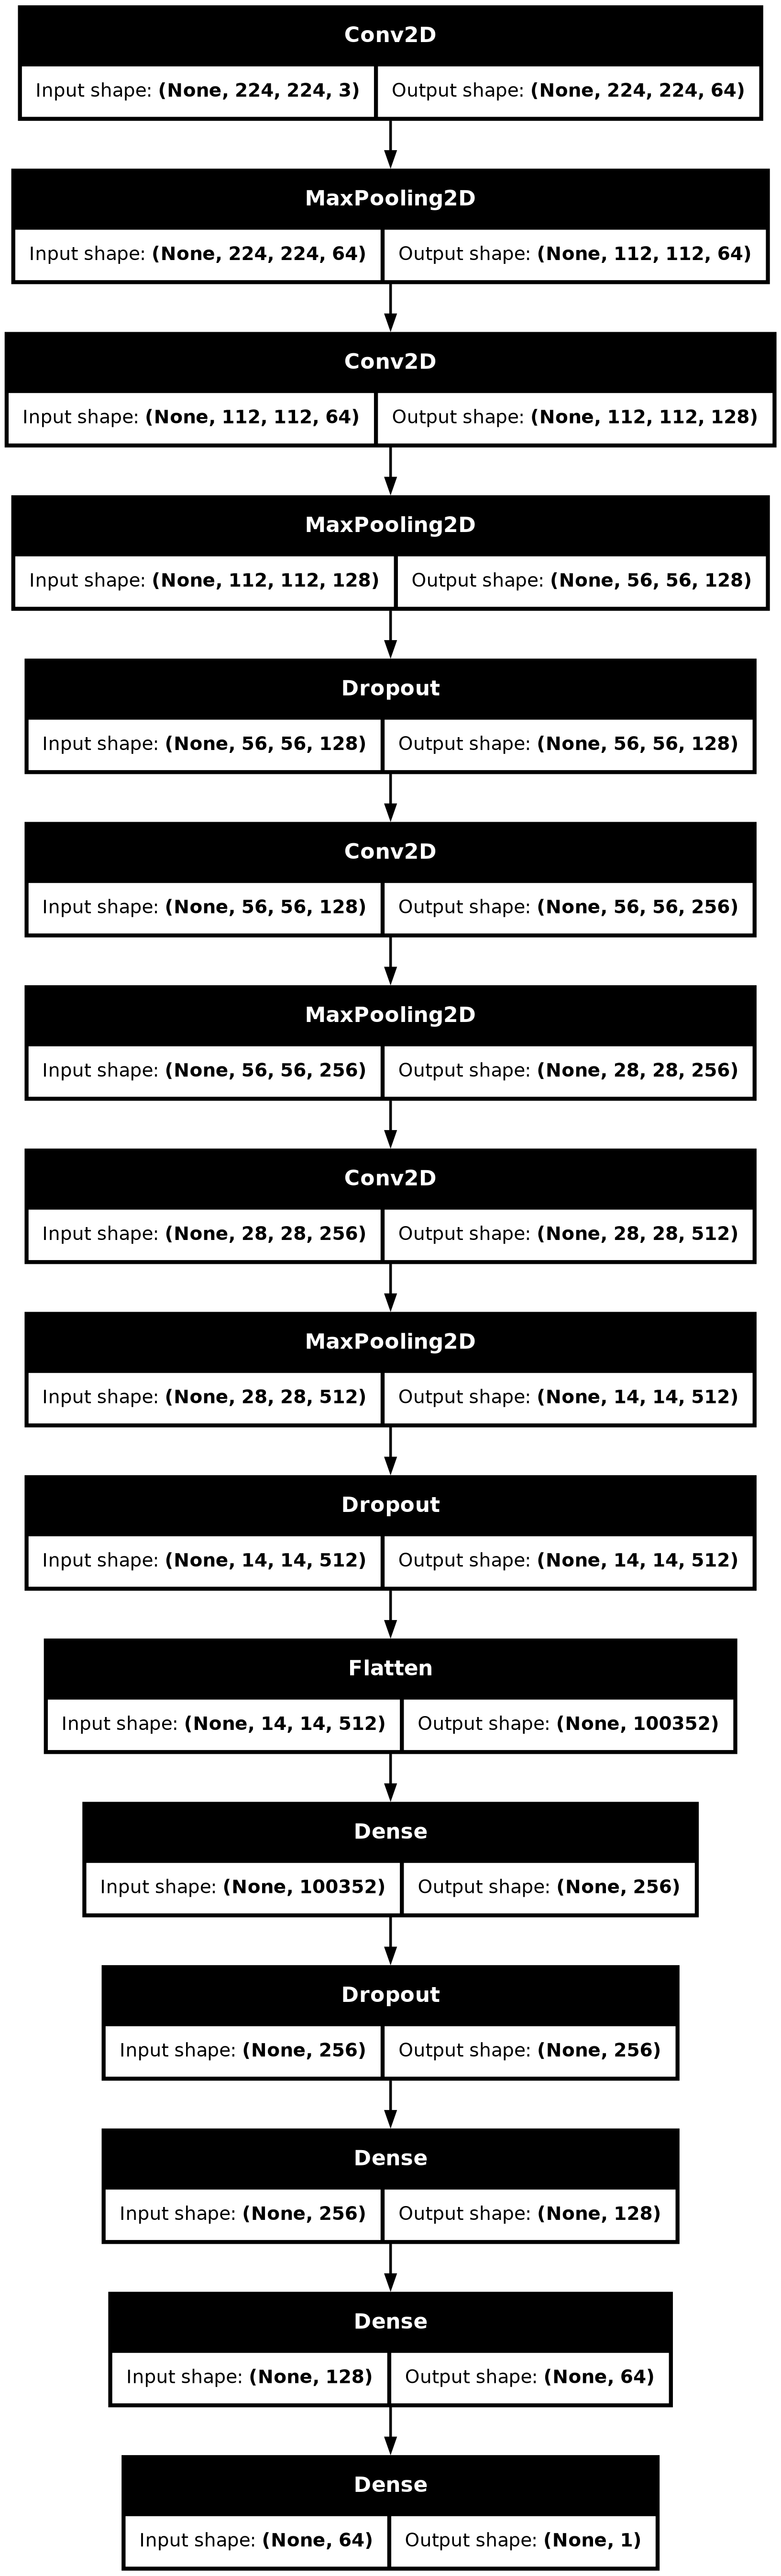

In [21]:
new_model = Sequential()
new_model.add(Conv2D(64, (3, 3), strides=(1, 1), 
                     activation="relu", 
                     padding="same", 
                     input_shape=(224, 224, 3)))
new_model.add(MaxPooling2D(pool_size=(2, 2)))

new_model.add(Conv2D(128, (3, 3), 
                     strides=(1, 1), 
                     padding="same", 
                     activation="relu"))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.3))

new_model.add(Conv2D(256, (3, 3), 
                     strides=(1, 1), 
                     padding="same", 
                     activation="relu"))
new_model.add(MaxPooling2D(pool_size=(2, 2)))

new_model.add(Conv2D(512, (3, 3), 
                     strides=(1, 1), 
                     padding="same", 
                     activation="relu"))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.3))

new_model.add(Flatten())

new_model.add(Dense(256, activation="relu")) 
new_model.add(Dropout(0.4)) 
new_model.add(Dense(128, activation="relu")) 
new_model.add(Dense(64, activation="relu"))
new_model.add(Dense(1, activation="sigmoid"))

keras.utils.plot_model(new_model, show_shapes=True)

In [22]:
new_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
new_model_hist = new_model.fit(train_set, validation_data=validation_set, epochs=10)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733797048.255416     965 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads



22/41 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7168 - loss: 0.6093

I0000 00:00:1733797113.914176     967 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads



41/41 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.7278 - loss: 0.5898 - val_accuracy: 0.7747 - val_loss: 0.4310
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8002 - loss: 0.3940 - val_accuracy: 0.8505 - val_loss: 0.3277
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8562 - loss: 0.3068 - val_accuracy: 0.8752 - val_loss: 0.2807
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.9055 - loss: 0.2253 - val_accuracy: 0.8370 - val_loss: 0.3363
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9065 - loss: 0.2284 - val_accuracy: 0.9356 - val_loss: 0.1723
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9221 - loss: 0.1959 - val_accuracy: 0.8949 - val_loss: 0.2402
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9334 - loss: 0.1908 - val_accuracy: 0.9077 - val_loss: 0.2246
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9388 - loss: 0.1682 - val_accuracy: 0.9170 - val_loss: 0.

## Analysis

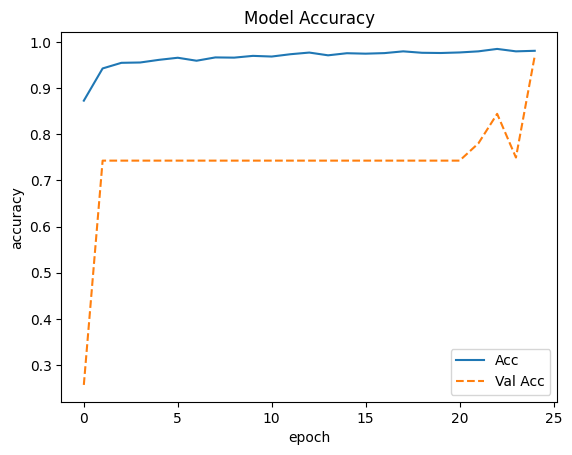

In [24]:
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'], linestyle='dashed')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Acc', 'Val Acc'], loc='lower right')
plt.show();

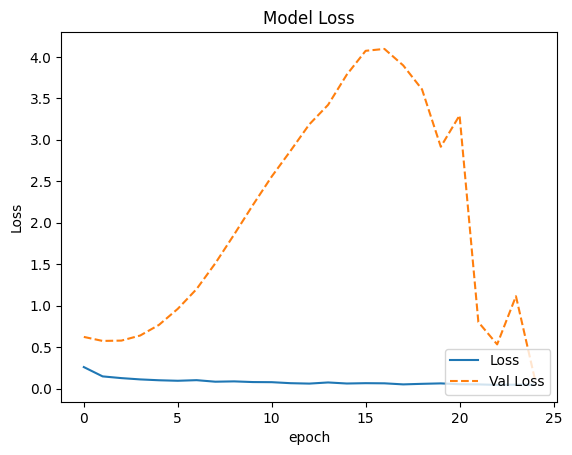

In [25]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'], linestyle='dashed')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Val Loss'], loc='lower right')
plt.show();

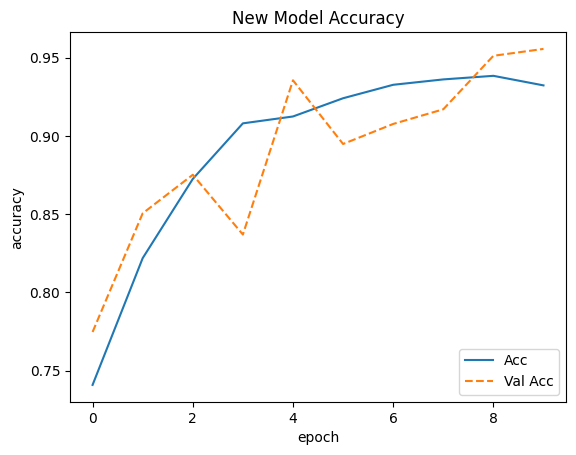

In [26]:
plt.plot(new_model_hist.history['accuracy'])
plt.plot(new_model_hist.history['val_accuracy'], linestyle='dashed')
plt.title('New Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Acc', 'Val Acc'], loc='lower right')
plt.show();

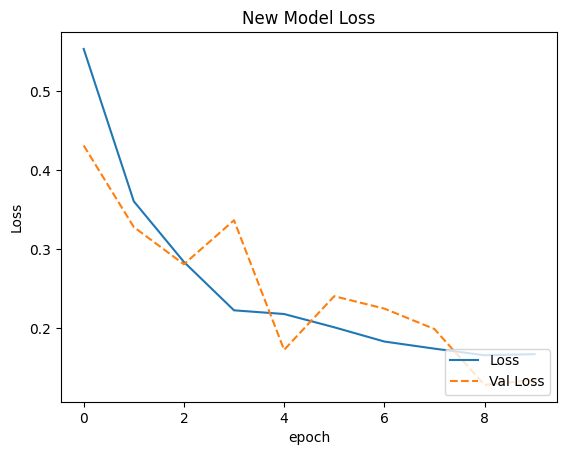

In [27]:
plt.plot(new_model_hist.history['loss'])
plt.plot(new_model_hist.history['val_loss'], linestyle='dashed')
plt.title('New Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Val Loss'], loc='lower right')
plt.show();

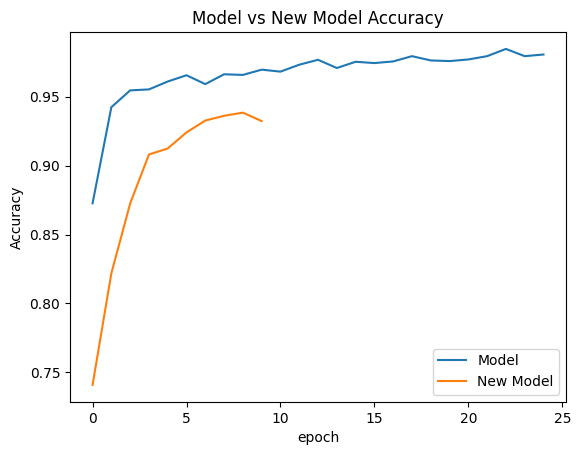

In [28]:
plt.plot(model_hist.history['acc'])
plt.plot(new_model_hist.history['accuracy'])
plt.title('Model vs New Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Model', 'New Model'], loc='lower right')
plt.show();

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The model is 65.68% confident this is a normal x-ray and 34.32% confident this is an x-ray of someone with pneumonia.


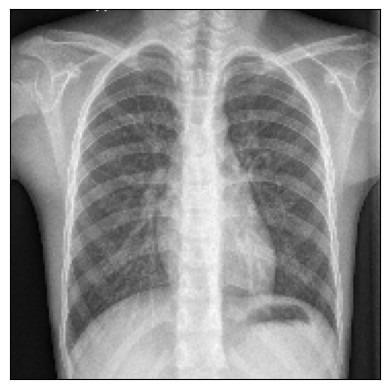

In [29]:
img = keras.utils.load_img("/kaggle/input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg", 
                           target_size=image_size
                          )
plt.xticks([])
plt.yticks([])
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"The model is {100 * (1 - score):.2f}% confident this is a normal x-ray and {100 * score:.2f}% confident this is an x-ray of someone with pneumonia.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The model is 0.00% confident this is a normal x-ray and 100.00% confident this is an x-ray of someone with pneumonia.


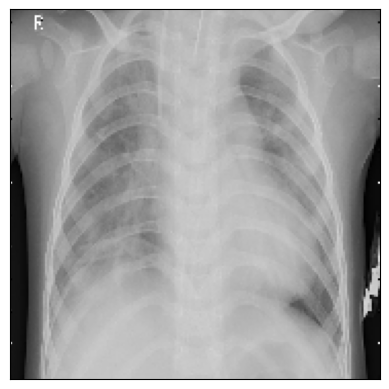

In [30]:
img = keras.utils.load_img("/kaggle/input/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg", 
                           target_size=image_size
                          )
plt.xticks([])
plt.yticks([])
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"The model is {100 * (1 - score):.2f}% confident this is a normal x-ray and {100 * score:.2f}% confident this is an x-ray of someone with pneumonia.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The new model is 26.89% confident this is a normal x-ray and 73.11% confident this is an x-ray of someone with pneumonia.


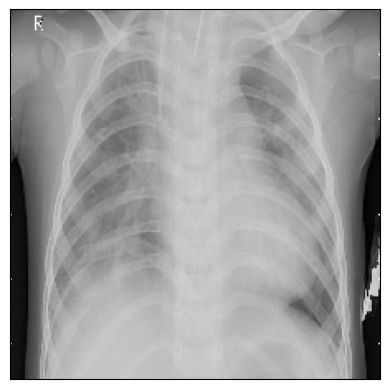

In [38]:
image_size = (224, 224)

img = keras.utils.load_img("/kaggle/input/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg", 
                           target_size=image_size
                          )
plt.xticks([])
plt.yticks([])
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"The new model is {100 * (1 - score):.2f}% confident this is a normal x-ray and {100 * score:.2f}% confident this is an x-ray of someone with pneumonia.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The new model is 63.38% confident this is a normal x-ray and 36.62% confident this is an x-ray of someone with pneumonia.


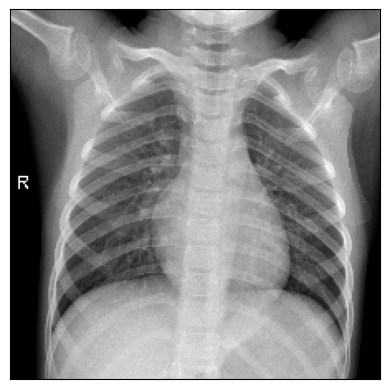

In [39]:
img = keras.utils.load_img("/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1012843-0001.jpeg", 
                           target_size=image_size
                          )
plt.xticks([])
plt.yticks([])
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"The new model is {100 * (1 - score):.2f}% confident this is a normal x-ray and {100 * score:.2f}% confident this is an x-ray of someone with pneumonia.")

## Conclusion

Both models performed well, the original model performed better in terms of accuracy, it had an accuracy score > .98, and speed, it took about 25 seconds per epoch, whereas the second model took 140 seconds per epoch. Because of the difference in performance, I chose to only run the second model for 10 epochs vs the 25 that I ran the first model.

All in all, we achieved our goal of building a model capable of detecting pneumonia in an individual's x-ray.